<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/flightontime_hackaton_e32_alura_latam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlightOnTime ✈️ Data Science

## Comportación final de los datasets presentados por miembros del equipo

Esa se basa en los resultados de evaluación previa de cada notebook

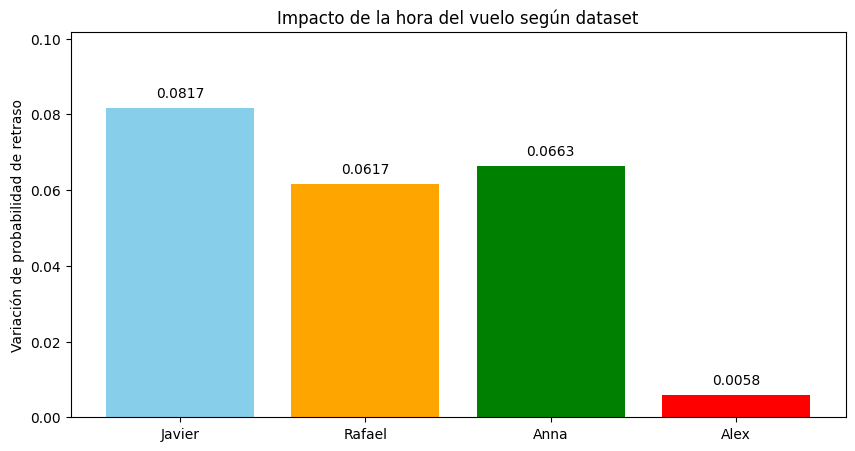

In [ ]:
# -*- coding: utf-8 -*-
"""analisis_final_dataset.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1NlCHZVZtU_LD4hKFcV36YE4ydFJUDSMJ
"""

# Comparación datasets

# Importamos librerías
import matplotlib.pyplot as plt

# DATOS: Variación de probabilidad de retraso según hora
# Este número mide el "impacto de la hora del vuelo"
nombres = ["Javier", "Rafael", "Anna", "Alex"]
variaciones = [0.08168772635113504, 0.0617, 0.06625976077440347, 0.005829360131785699]

plt.figure(figsize=(10,5))
bars = plt.bar(nombres, variaciones, color=["skyblue", "orange", "green", "red"])
plt.ylabel("Variación de probabilidad de retraso")
plt.title("Impacto de la hora del vuelo según dataset")

# Añadimos los valores exactos encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, round(yval,4), ha='center', va='bottom')

plt.ylim(0, max(variaciones)+0.02)
plt.show()


1. Qué significa "impacto de la hora del vuelo":
   - Es cuánto cambia la probabilidad de retraso según la hora a la que sale el vuelo.
   - Un valor alto significa que la hora importa mucho; un valor bajo significa que importa poco.

2. Qué significan los números:
   - Javier: 0.0817 → la hora tiene mucho efecto, pero es menos consistente.
   - Rafael: 0.0617 → la hora tiene efecto medio, pero es estable y fiable.
   - Anna: 0.0663 → efecto medio, pero no captura todos los patrones.
   - Alex: 0.00583 → la hora casi no afecta los retrasos; el dataset captura muy poca señal horaria.

3. Por qué elegir Rafael:
   - Nos da información clara y consistente sobre cuándo es más probable un retraso.
   - Evita confundirnos con valores ruidosos o inconsistentes.
   - Es como elegir la brújula más fiable: apunta bien aunque no sea el número más alto.

_Rafael nos dice claramente qué horas afectan los retrasos y lo hace de manera consistente, por eso es el dataset más fiable para predecir vuelos retrasados._

### POR QUÉ ES IMPORTANTE QUE EL IMPACTO DE LA HORA SEA BAJO

    El impacto de la hora del vuelo mide cuánto cambia la probabilidad
    de retraso según la hora de salida.

    Un valor muy alto no implica mejor información. Suele indicar problemas de estabilidad.

### **Impacto alto**

    - Grandes cambios de probabilidad según la hora.
    - Puede deberse a ruido o pocos datos.
    - Modelo muy sensible y poco generalizable.

### **Impacto bajo o moderado**

    - La hora influye de forma controlada.
    - Patrón más estable y consistente.
    - Representa mejor la realidad.

### **Impacto muy bajo**

    - La probabilidad de retraso apenas cambia según la hora.
    - La señal horaria es débil o ausente.
    - Modelos que usan este dataset no podrán aprovechar la hora como predictor.
    - Esto hace que el dataset sea poco útil para analizar retrasos por hora.

### **Ventaja principal**

    - Reduce el sobreajuste.
    - Mejora la generalización.
    - Predicciones más fiables.

### **Conclusión**

   ---
  > Un impacto bajo indica un efecto real y estable, haciendo el dataset
    más confiable para predecir retrasos de vuelos. Sin embargo, si el
    impacto es muy bajo, como en Alex, la señal horaria se pierde y
    el dataset deja de ser útil para este criterio.
    Si mi vuelo sale a las 6 am o a las 6 pm, ¿cambia mucho la probabilidad de retraso?

# **1. Carga y Exploración Inicial (Profiling)**

---------

## Descargar el dataset de Rafael para el analisis e entrenamiento

In [ ]:
!pip install kagglehub pyarrow requests

In [ ]:
import kagglehub
import pandas as pd
import pyarrow.parquet as pq

path = kagglehub.dataset_download("arvindnagaonkar/flight-delay")
print(path)

parquet_file = "/kaggle/input/flight-delay/Flight_Delay.parquet"
n_sample = 100_000   #Limito filas

pf = pq.ParquetFile(parquet_file)  #Abre parte del parquet si cargarse la memoria

#columnas que necesitamos
'''
columns_needed = [
    "FlightDate",
    "OriginCityName",
    "CRSDepTime",
    "DepDelay",
    "Distance",
    "Marketing_Airline_Network"
]
'''

Using Colab cache for faster access to the 'flight-delay' dataset.
/kaggle/input/flight-delay


'\ncolumns_needed = [\n    "FlightDate",\n    "OriginCityName",\n    "CRSDepTime",\n    "DepDelay",\n    "Distance",\n    "Marketing_Airline_Network"\n]\n'

## Cargar dataset por bloques

In [ ]:
#loop muestreo. Lee parquet por bloques, junta filas, no carga todo el dataset.
rows = []
rows_read = 0

for batch in pf.iter_batches(batch_size=50_000): #, columns=columns_needed):
    df_batch = batch.to_pandas()
    remaining = n_sample - rows_read
    if remaining <= 0:
        break
    if len(df_batch) > remaining:
        df_batch = df_batch.sample(remaining, random_state=42)
    rows.append(df_batch)
    rows_read += len(df_batch)

#dataframe resultado uniendo batches

df = pd.concat(rows, ignore_index=True)


## **Inspección visual**




### Visualizar las primeras 5 filas.

In [ ]:
df.head()

,Year,Month,DayofMonth,FlightDate,Marketing_Airline_Network,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelay,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,1,15,2018-01-15,UA,"Newark, NJ","Charleston, SC",1845,1928.0,43.0,...,143.0,141.0,102.0,628.0,3,41.0,0.0,0.0,0.0,0.0
1,2018,1,16,2018-01-16,UA,"Newark, NJ","Charleston, SC",1835,1956.0,81.0,...,143.0,131.0,108.0,628.0,3,67.0,0.0,0.0,0.0,2.0
2,2018,1,17,2018-01-17,UA,"Newark, NJ","Charleston, SC",1835,1836.0,1.0,...,143.0,138.0,113.0,628.0,3,0.0,0.0,0.0,0.0,0.0
3,2018,1,18,2018-01-18,UA,"Newark, NJ","Charleston, SC",1845,1844.0,-1.0,...,143.0,134.0,92.0,628.0,3,0.0,0.0,0.0,0.0,0.0
4,2018,1,20,2018-01-20,UA,"Newark, NJ","Charleston, SC",1835,1829.0,-6.0,...,143.0,117.0,89.0,628.0,3,0.0,0.0,0.0,0.0,0.0


### **Estructura**

*   Revisar cuántas filas y columnas hay.

In [ ]:
print(f"Cantidad de columnas y filas: {df.shape}")

Cantidad de columnas y filas: (100000, 29)


*   Qué tipo de datos contiene cada una (¿son números, fechas, texto?)

In [ ]:
df.dtypes

,0
Year,int64
Month,int64
DayofMonth,int64
FlightDate,object
Marketing_Airline_Network,object
OriginCityName,object
DestCityName,object
CRSDepTime,int64
DepTime,float64
DepDelay,float64


### **Estadística básica**

*   Calcular medias, medianas y desviaciones estándar para entender la distribución de los números.

In [ ]:
df.describe()

,Year,Month,DayofMonth,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,TaxiOut,WheelsOff,WheelsOn,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,100000.0,100000.0,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.0,1.0,14.879780,1327.535980,1335.14702,10.116290,13.661770,15.976660,1358.813680,1467.842620,...,137.979840,130.186510,107.180340,764.650600,3.527760,4.647050,0.703230,2.550650,0.018280,5.256900
std,0.0,0.0,9.050645,487.958328,498.49002,49.230517,48.086319,9.642199,498.267314,521.188453,...,74.304854,72.336005,69.939664,586.343365,2.280382,32.336684,13.665402,15.254682,1.211726,25.825928
min,2018.0,1.0,1.000000,1.000000,1.00000,-45.000000,0.000000,1.000000,1.000000,1.000000,...,18.000000,11.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.0,1.0,7.000000,915.000000,920.00000,-6.000000,0.000000,10.000000,934.000000,1049.000000,...,85.000000,79.000000,58.000000,345.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.0,1.0,15.000000,1319.000000,1329.00000,-3.000000,0.000000,14.000000,1342.000000,1506.000000,...,120.000000,113.000000,89.000000,604.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.0,1.0,23.000000,1730.000000,1741.00000,4.000000,4.000000,18.000000,1755.000000,1910.000000,...,171.000000,162.000000,137.000000,1005.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2018.0,1.0,31.000000,2359.000000,2400.00000,1682.000000,1682.000000,157.000000,2400.000000,2400.000000,...,704.000000,712.000000,683.000000,4983.000000,11.000000,1469.000000,1682.000000,1317.000000,264.000000,1342.000000



---

> **Aquí las estadísticas clave que estás viendo**:
>
> - **count (conteo)**: Es el número de observaciones no nulas en cada columna. En este conjunto de datos, todas las columnas numéricas tienen 100,000 entradas, lo que significa que no hay valores faltantes en estas columnas.
>
> - **mean (media)**: Es el valor promedio de cada columna. Por ejemplo, el promedio de `DepDelay` (retraso de salida) es de aproximadamente 10.12 minutos, y la distancia promedio de los vuelos es de alrededor de 764.65 millas.
>
> - **std (desviación estándar)**: Mide la cantidad de variación o dispersión de un conjunto de valores. Una desviación estándar alta indica que los datos están más dispersos, mientras que una baja indica que los datos tienden a estar cerca de la media. Por ejemplo, `DepDelay` tiene una desviación estándar de 49.23, lo que es bastante alto en comparación con su media, sugiriendo que hay una variabilidad significativa en los retrasos de salida.
>
> - **min (mínimo)**: Es el valor mínimo en cada columna. Para `DepDelay`, el mínimo es -45, lo que indica que algunos vuelos salieron 45 minutos antes de lo programado.
>
> - **25% (Q1)**: Es el primer cuartil, lo que significa que el 25% de los datos están por debajo de este valor.
>
> - **50% (Q2)**: Es el segundo cuartil o mediana, que es el valor medio cuando los datos están ordenados. Para `DepDelay`, la mediana es de -3 minutos, lo que implica que al menos la mitad de los vuelos salieron a tiempo o antes.
>
> - **75% (Q3)**: Es el tercer cuartil, lo que significa que el 75% de los datos están por debajo de este valor.
>
> - **max (máximo)**: Es el valor máximo en cada columna. Para `DepDelay`, el máximo es de 1682 minutos, lo que indica que algunos vuelos experimentaron retrasos muy largos.



# **2. Limpieza de Datos (Data Cleaning)**

### **Valores faltantes**

*   ¿Hay celdas vacías? Debes decidir si borras esas filas o rellenas los huecos con la media o un valor lógico.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Year                       100000 non-null  int64  
 1   Month                      100000 non-null  int64  
 2   DayofMonth                 100000 non-null  int64  
 3   FlightDate                 100000 non-null  object 
 4   Marketing_Airline_Network  100000 non-null  object 
 5   OriginCityName             100000 non-null  object 
 6   DestCityName               100000 non-null  object 
 7   CRSDepTime                 100000 non-null  int64  
 8   DepTime                    100000 non-null  float64
 9   DepDelay                   100000 non-null  float64
 10  DepDelayMinutes            100000 non-null  float64
 11  TaxiOut                    100000 non-null  float64
 12  WheelsOff                  100000 non-null  float64
 13  WheelsOn                   100

---
> Según la salida de `df.info()`, todas las columnas en ese conjunto de datos muestran un conteo de no nulos de 100,000, lo que coincide con el índice de rango total de 100,000 entradas. Esto significa que no hay valores faltantes en este DataFrame. Por lo tanto, no es necesario tomar ninguna medida para eliminar filas o llenar espacios vacíos.

### **Duplicados**

*   Eliminar registros repetidos que puedan sesgar los resultados.

In [ ]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


---
> La salida muestra: `"Number of duplicate rows: 0"`. Esto significa que no hay entradas duplicadas en el DataFrame, por lo que no es necesario tomar medidas adicionales para eliminarlas.



### **Formateo**

*  Asegurarse de que las fechas sean tratadas como fechas y no como simple texto.
*  Convertir fecha/hora a datetime.

In [ ]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'])
print(df['FlightDate'].dtypes)

datetime64[ns]


---


> La columna `FlightDate` se ha convertido exitosamente al tipo de dato `datetime64[ns]`, lo que significa que está correctamente formateada para cualquier operación o análisis basado en fechas.



# **3. Análisis Exploratorio de Datos (EDA)**

## **Detección de Outliers**

Identificar valores atípicos (por ejemplo, un sueldo de un billón de dólares en una lista de empleados comunes) que podrían arruinar el modelo.

## **Correlaciones**

¿Si la variable A sube, la variable B también? Esto nos dirá qué datos son realmente importantes para la predicción.

## **Distribuciones**

*   Revisar si los datos siguen una curva normal o si están muy sesgados hacia un lado.
*   Buscar patrones usando gráficos (Matplotlib, Seaborn o Plotly).